In [1]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import csv
import math
from tensorflow import keras


import cv2
import numpy as np
from keras import Model
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import MaxPooling2D, Conv2D, Reshape, Dense, Flatten
import tensorflow as tf
from keras.datasets import cifar10
import sys
import matplotlib.pyplot as plt
print(tf.__version__)
#print(tf.keras.__version__)

#testing the GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.15.0
Found GPU at: /device:GPU:0


### Import Dataset

In [2]:
# Class names for different classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

# Load training data, labels; and testing data and their true labels
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print ('Training data size:', train_images.shape, 'Test data size', test_images.shape)

# Normalize pixel values between -1 and 1 [you can normalize between 0 and 1 also]
train_images = train_images / 127.5 - 1
test_images = test_images / 127.5 - 1

train_labels.shape

Training data size: (50000, 32, 32, 3) Test data size (10000, 32, 32, 3)


(50000, 1)

### Visualize dataset

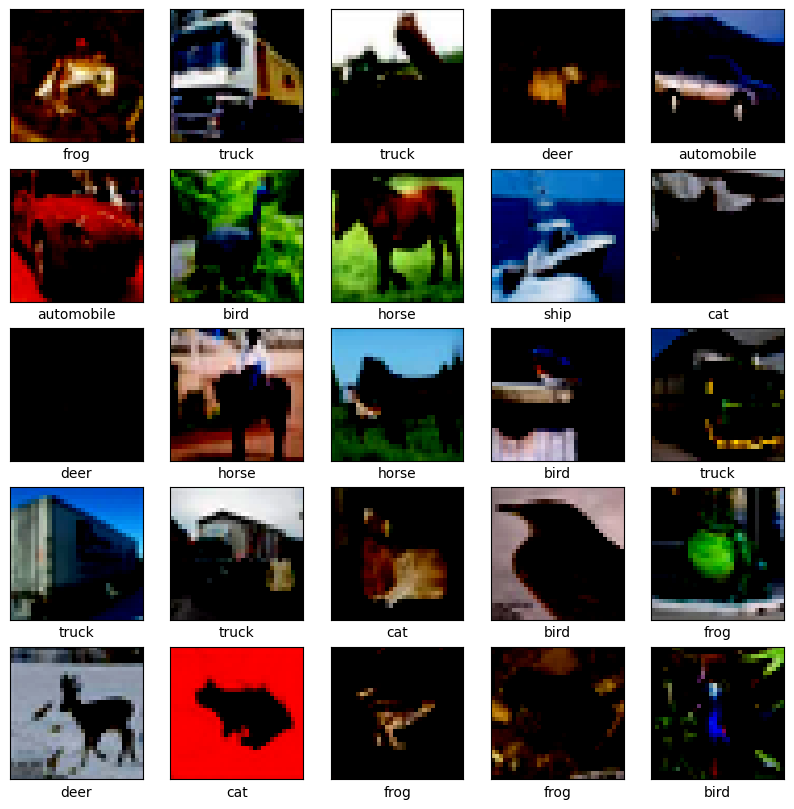

In [3]:
%matplotlib inline
#Show first 25 training images below
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])

### Resize images for use with MobileNetV2

In [4]:
# Upsize all training and testing images to 96x96 for use with mobile net
minSize = 96 #minimum size requried for mobileNetV2
# You may use cv2 package. Look for function:
#"cv2.resize(<originalImage>, dsize=(minSize, minSize), interpolation=cv2.INTER_AREA)"
# resize train image: You can first initialize a numpy array resized_train_images to store all the resized training images
resized_train_images = np.zeros((10000, minSize, minSize, 3), dtype=np.float32)
# <Write code for resizing>
for i in range(10000):
    resized_train_images[i] = cv2.resize(train_images[i], dsize=(minSize, minSize), interpolation=cv2.INTER_AREA)
# resize test image: You can first initialize a numpy array resized_test_images to store all the resized test images
resized_test_images = np.zeros((10000, minSize, minSize, 3), dtype=np.float32)
# <Write code for resizing>
for i in range(10000):
    resized_test_images[i] = cv2.resize(test_images[i], dsize=(minSize, minSize), interpolation=cv2.INTER_AREA)

(resized_train_images.shape, resized_test_images.shape)


((10000, 96, 96, 3), (10000, 96, 96, 3))

### Download MobileNetV2 model



In [5]:
#<Write code for downloading MobileNetV2>

# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(minSize, minSize, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


### Add custom layers at the end of downloaded model

In [6]:
#<Write code for adding custom layers>
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
# Create a new Sequential model
model = Sequential()

# Add the pre-trained base model
model.add(base_model)


# Add the rest of the layers
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))  # 10 classes for CIFAR-10


### Add loss function, compile and train the model, and check accuracy on test data

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Limit the training data and labels to 10,000 samples
limited_train_images = resized_train_images
limited_train_labels = train_labels[:10000]

# Compile the model with sparse categorical crossentropy
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(limited_train_images, limited_train_labels, batch_size=64, epochs=50,
                    validation_data=(resized_test_images, test_labels), callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(resized_test_images, test_labels, verbose=1)

print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/50
157/157 [==============================] - 20s 78ms/step - loss: 0.9554 - accuracy: 0.6790 - val_loss: 0.7351 - val_accuracy: 0.7427
Epoch 2/50
157/157 [==============================] - 6s 38ms/step - loss: 0.5715 - accuracy: 0.7978 - val_loss: 0.7501 - val_accuracy: 0.7443
Epoch 3/50
157/157 [==============================] - 6s 40ms/step - loss: 0.4413 - accuracy: 0.8450 - val_loss: 0.6973 - val_accuracy: 0.7705
Epoch 4/50
157/157 [==============================] - 8s 53ms/step - loss: 0.3546 - accuracy: 0.8785 - val_loss: 0.7296 - val_accuracy: 0.7607
Epoch 5/50
157/157 [==============================] - 9s 55ms/step - loss: 0.2564 - accuracy: 0.9164 - val_loss: 0.7614 - val_accuracy: 0.7579
Epoch 6/50
157/157 [==============================] - 6s 40ms/step - loss: 0.1791 - accuracy: 0.9472 - val_loss: 0.7866 - val_accuracy: 0.7666
Epoch 7/50
157/157 [==============================] - 6s 38ms/step - loss: 0.1281 - accuracy: 0.9646 - val_loss: 0.8054 - val_accuracy: 0.763

### Extra code for producing different plots

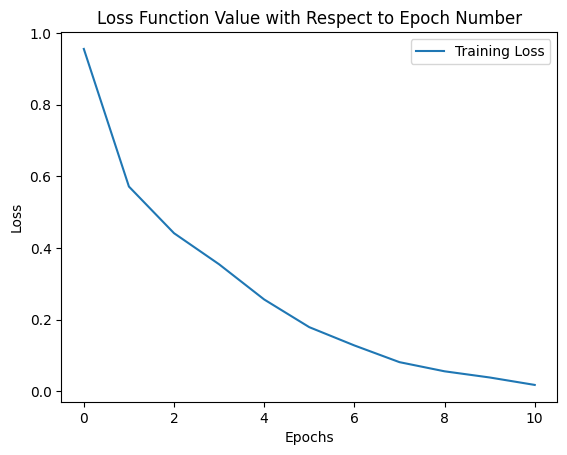

In [8]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.plot(history.history['loss'], label='Training Loss')

plt.title('Loss Function Value with Respect to Epoch Number')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()